# Exploring AI Mentions in Earnings Calls and Building Thematic Portfolios

## Introduction

In recent years, artificial intelligence (AI) has emerged as a central pillar of innovation across various industries. As companies increasingly emphasize AI in their business strategies, earnings calls have become an important source of insights for investors seeking to understand corporate priorities and market trends.

This article examines how the frequency and sentiment of AI mentions in earnings calls have evolved over time and whether these patterns can indicate a company's long-term growth potential. To uncover these insights, we conducted an exploratory analysis of earnings call transcripts from companies across diverse sectors leveraging LSEG MarketPsych Transcripts Analytics (MTA)  API. Additionally, we developed thematic portfolios based on these insights and tracked their historical performance to assess whether investing in AI-focused companies can yield significant returns.

The article is structured into three sections: setting up the dataset, conducting exploratory analysis, and building thematic portfolios.

## Import relevent libraries

To start, we first install and import the necessary packages. We use the [Refinitiv Data Libraries](https://developers.lseg.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-library-for-python) to retrieve the company universe for the analyis and [LSEG MarketPsych Transcripts Analytics (MTA)](https://www.marketpsych.com/transcripts/guide/overview) API for earnings transcripts. The code is built using Python 3.9. The prerequisite packages are imported as shown below. Please make sure you have them installed.

In [36]:
import requests
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import refinitiv.data as rd

from refinitiv.data.discovery import convert_symbols, SymbolTypes
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans

rd.get_config()["http.request-timeout"] = 60

## Section 1: Setting up the dataset

### Getting the company universe for the analysis

The first step is to define the universe of companies for which we will request transcript data from MTA. For a robust analysis, it's important to include a large number of companies across various economic sectors. Therefore, we have chosen the constituents of the [Russell 1000]((https://www.lseg.com/en/ftse-russell/indices/russell-us/russell-1000)) index as our universe, which encompasses all large-cap companies in the US.

Since our primary objective is to conduct an exploratory analysis rather than develop a comprehensive portfolio construction strategy, we will use the current list of Russell 1000 constituents. For a more in-depth analysis of portfolio performance, it is advisable to track changes in index constituents over time (e.g., each quarter). In this regard, [this article](https://developers.lseg.com/en/article-catalog/article/building-historical-index-constituents) provides useful functions for retrieving historical index constituent data.

To begin, we open an API session and request the data for the universe of companies using RD Libraries for Python. Additionally, to implement also a sectoral analysis, we request information on the economic sectors of these companies.

In [37]:
rd.open_session()

<refinitiv.data.session.Definition object at 0x308590850 {name='workspace'}>

In [38]:
universe = rd.get_data('0#.RUI', 'TR.TRBCEconomicSector')
universe

,Instrument,TRBC Economic Sector Name
0,AIZ.N,Financials
1,GME.N,Consumer Cyclicals
2,KEYS.N,Technology
3,QCOM.OQ,Technology
4,KMPR.N,Financials
...,...,...
1005,NLY.N,Real Estate
1006,MA.N,Technology
1007,BIIB.OQ,Healthcare
1008,SYF.N,Financials


The request above returned the RICs of the FTSE 1000 contituent companies alongside with the economic sectors they represent. To request the transcripts data via MTA though, we need to use company perm_ids, therefore we leverage symbology conversion of the RD Libraries to get the perm_ids of our universe.

In [39]:
universe_rics = universe['Instrument'].to_list()

universe_perm_ids = convert_symbols(universe_rics, 
    from_symbol_type=SymbolTypes.RIC,
    to_symbol_types=[SymbolTypes.OA_PERM_ID],
)

universe_perm_ids

,DocumentTitle,IssuerOAPermID
AIZ.N,"Assurant Inc, Ordinary Share, New York Stock Exchange",4295899478
GME.N,"GameStop Corp, Ordinary Share, Class A, New York Stock Exchange",4295902037
KEYS.N,"Keysight Technologies Inc, Ordinary Share, New York Stock Exchange",5041978269
QCOM.OQ,"Qualcomm Inc, Ordinary Share, NASDAQ Stock Exchange Global Select Market",4295907706
KMPR.N,"Kemper Corp, Ordinary Share, New York Stock Exchange",4295908262
...,...,...
NLY.N,"Annaly Capital Management Inc, Ordinary Share, New York Stock Exchange",4295903438
MA.N,"Mastercard Inc, Ordinary Share, Class A, New York Stock Exchange",4295902520
BIIB.OQ,"Biogen Inc, Ordinary Share, NASDAQ Stock Exchange Global Select Market",4295906748
SYF.N,"Synchrony Financial, Ordinary Share, New York Stock Exchange",5042214022


Now let's merge the requested perm_ids with our initial universe.

In [40]:
universe_perm_ids.drop_duplicates(subset = 'IssuerOAPermID', inplace =True)
universe = universe.merge(universe_perm_ids, left_on='Instrument', right_index=True)
universe

,Instrument,TRBC Economic Sector Name,DocumentTitle,IssuerOAPermID
0,AIZ.N,Financials,"Assurant Inc, Ordinary Share, New York Stock Exchange",4295899478
1,GME.N,Consumer Cyclicals,"GameStop Corp, Ordinary Share, Class A, New York Stock Exchange",4295902037
2,KEYS.N,Technology,"Keysight Technologies Inc, Ordinary Share, New York Stock Exchange",5041978269
3,QCOM.OQ,Technology,"Qualcomm Inc, Ordinary Share, NASDAQ Stock Exchange Global Select Market",4295907706
4,KMPR.N,Financials,"Kemper Corp, Ordinary Share, New York Stock Exchange",4295908262
...,...,...,...,...
1005,NLY.N,Real Estate,"Annaly Capital Management Inc, Ordinary Share, New York Stock Exchange",4295903438
1006,MA.N,Technology,"Mastercard Inc, Ordinary Share, Class A, New York Stock Exchange",4295902520
1007,BIIB.OQ,Healthcare,"Biogen Inc, Ordinary Share, NASDAQ Stock Exchange Global Select Market",4295906748
1008,SYF.N,Financials,"Synchrony Financial, Ordinary Share, New York Stock Exchange",5042214022


### Getting the transcripts for our universe

Once we have our universe defined, let's request the transcripts data useing MTA API. The API allows single and multi-asset ingestion and offers document, sector, speaker and sentence level of request granularity. In the scope of our analysis, we will go for multi-asset sentence level request. Furthermore, we will benefit from the searching capabilities of the API and ask only for sentences containing word AI. More about the MTA API and it's capabilities can be found in the [official documentation](https://www.marketpsych.com/transcripts/guide/overview).


Before making our request though, below we provide a wrapper function that simplifies the process of fetching data from the API and by directly loading it into a pandas DataFrame.

In [41]:
def create_df(url: str) -> pd.DataFrame:
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Query failed with status code {response.status_code}: {response.json().get('error')}")
    data = response.json()['data']
    return pd.DataFrame(data)

In [42]:
def chunk_list(lst: list, chunk_size: int) -> list:
    for i in range(0, len(lst), chunk_size):
        yield lst[i:i + chunk_size]

To begin, you'll need to replace APIKEY in the code snippet below with your API key provided by LSEG/MarketPsych. Further, we define the remaining request parameters and leverage the function above for the chunks of our universe. We devide our original universe into chunks to respect the API limits uning chunk_list function introduced below.

In [62]:
APIKEY = "" # Replace the following with your API key

chunk_size = 500
perm_ids_chunks = list(chunk_list(universe['IssuerOAPermID'], chunk_size))

start_date = '2016-01-01'
end_date = '2024-06-03'
search_word = 'AI'

events_df = pd.DataFrame()

for perm_ids in perm_ids_chunks:
    perm_ids_str = ','.join(perm_ids)
    url = f"https://dataapi.marketpsych.com/mta/data/{perm_ids_str}?apikey={APIKEY}&aggregation_type=sentence&start_date={start_date}&end_date={end_date}&event_type=ecc&dedup=True&search={search_word}&format=json"
    df = create_df(url)
    events_df = pd.concat([events_df, df])
events_df

,_id,document.id,document.status,document.last_edited,event.name,...,emotions.surprise,emotions.neutral,publ_time,search_matches,proc_time
0,26abbeefff5e6b4b07f5b8e9bb91f168_q-and-a_24_markmahaney_4,26abbeefff5e6b4b07f5b8e9bb91f168,EDITED,2016-07-20T22:52:23,Q2 2016 eBay Inc Earnings Call,...,0.00,0.07,1469048400,[AI],NaN
1,26abbeefff5e6b4b07f5b8e9bb91f168_q-and-a_25_devinwenig_13,26abbeefff5e6b4b07f5b8e9bb91f168,EDITED,2016-07-20T22:52:23,Q2 2016 eBay Inc Earnings Call,...,0.00,0.00,1469048400,[AI],NaN
2,26abbeefff5e6b4b07f5b8e9bb91f168_q-and-a_25_devinwenig_14,26abbeefff5e6b4b07f5b8e9bb91f168,EDITED,2016-07-20T22:52:23,Q2 2016 eBay Inc Earnings Call,...,0.00,0.01,1469048400,[AI],NaN
3,65f5e52dc2cad1e9f691e7bfcde0c3c2_q-and-a_68_darakhosrowshahi_1,65f5e52dc2cad1e9f691e7bfcde0c3c2,EDITED,2016-11-15T15:17:07,Q3 2016 Expedia Inc Earnings Call,...,0.00,0.01,1477600200,[AI],NaN
4,65f5e52dc2cad1e9f691e7bfcde0c3c2_q-and-a_68_darakhosrowshahi_13,65f5e52dc2cad1e9f691e7bfcde0c3c2,EDITED,2016-11-15T15:17:07,Q3 2016 Expedia Inc Earnings Call,...,0.00,0.01,1477600200,[AI],NaN
...,...,...,...,...,...,...,...,...,...,...,...
15146,0a5d615bb8de9976d23874d45100265b_q-and-a_37_shrenikkothari_7,0a5d615bb8de9976d23874d45100265b,EDITED,2024-05-31T20:36:10Z,Q3 2024 Zscaler Inc Earnings Call,...,0.00,0.24,1717101000,[AI],1.717188e+09
15147,0a5d615bb8de9976d23874d45100265b_q-and-a_38_jagtarchaudhry_4,0a5d615bb8de9976d23874d45100265b,EDITED,2024-05-31T20:36:10Z,Q3 2024 Zscaler Inc Earnings Call,...,0.01,0.75,1717101000,[AI],1.717188e+09
15148,0a5d615bb8de9976d23874d45100265b_q-and-a_38_jagtarchaudhry_6,0a5d615bb8de9976d23874d45100265b,EDITED,2024-05-31T20:36:10Z,Q3 2024 Zscaler Inc Earnings Call,...,0.00,1.00,1717101000,[AI],1.717188e+09
15149,0a5d615bb8de9976d23874d45100265b_q-and-a_54_adamborg_3,0a5d615bb8de9976d23874d45100265b,EDITED,2024-05-31T20:36:10Z,Q3 2024 Zscaler Inc Earnings Call,...,0.00,0.01,1717101000,[AI],1.717188e+09


The resulting dataframe includes around 28,000 sentences from our universe, dating back to January 2016. It encompasses a broad range of emotion and sentiment metrics for each sentence. Additionally, each entry is provided with metadata related to the event, company, and speaker. A complete list of the output fields and their descriptions is available in the [documentation](https://www.marketpsych.com/transcripts/guide/fields). 

To make our final dataset ready for the analysis, we merge the transcripts data above with the universe data we obtained in the previous section and sort the values by the start date of the event.

In [63]:
events_df['company.permid'] = events_df['company.permid'].astype(str)
events_df = events_df.merge(universe, left_on = 'company.permid', right_on='IssuerOAPermID', how='inner')
events_df['start_date'] = pd.to_datetime(events_df['event.start_date']).dt.date
events_df = events_df.sort_values(by='start_date')
events_df

,_id,document.id,document.status,document.last_edited,event.name,...,Instrument,TRBC Economic Sector Name,DocumentTitle,IssuerOAPermID,start_date
26761,27802443a70d9e0f251ef41cb1cc33bc_q-and-a_71_jeffzekauskas_1,27802443a70d9e0f251ef41cb1cc33bc,EDITED,2016-02-08T18:33:03,Q4 2015 Celanese Corp Earnings Call,...,CE.N,Basic Materials,"Celanese Corp, Ordinary Share, New York Stock Exchange",4295899696,2016-01-22
26762,27802443a70d9e0f251ef41cb1cc33bc_q-and-a_76_hassanahmed_2,27802443a70d9e0f251ef41cb1cc33bc,EDITED,2016-02-08T18:33:03,Q4 2015 Celanese Corp Earnings Call,...,CE.N,Basic Materials,"Celanese Corp, Ordinary Share, New York Stock Exchange",4295899696,2016-01-22
26763,27802443a70d9e0f251ef41cb1cc33bc_q-and-a_76_hassanahmed_6,27802443a70d9e0f251ef41cb1cc33bc,EDITED,2016-02-08T18:33:03,Q4 2015 Celanese Corp Earnings Call,...,CE.N,Basic Materials,"Celanese Corp, Ordinary Share, New York Stock Exchange",4295899696,2016-01-22
26764,27802443a70d9e0f251ef41cb1cc33bc_q-and-a_76_hassanahmed_7,27802443a70d9e0f251ef41cb1cc33bc,EDITED,2016-02-08T18:33:03,Q4 2015 Celanese Corp Earnings Call,...,CE.N,Basic Materials,"Celanese Corp, Ordinary Share, New York Stock Exchange",4295899696,2016-01-22
26760,27802443a70d9e0f251ef41cb1cc33bc_q-and-a_31_davidbegleiter_2,27802443a70d9e0f251ef41cb1cc33bc,EDITED,2016-02-08T18:33:03,Q4 2015 Celanese Corp Earnings Call,...,CE.N,Basic Materials,"Celanese Corp, Ordinary Share, New York Stock Exchange",4295899696,2016-01-22
...,...,...,...,...,...,...,...,...,...,...,...
7464,2230d6cc7af5758dee354274af96141c_q-and-a_2_krishsankar_5,2230d6cc7af5758dee354274af96141c,EDITED,2024-05-31T07:16:34Z,Q1 2025 Dell Technologies Inc Earnings Call,...,DELL.N,Technology,"Dell Technologies Inc, Ordinary Share, Class C, New York Stock Exchange",5040186364,2024-05-30
7465,2230d6cc7af5758dee354274af96141c_q-and-a_30_amitdaryanani_2,2230d6cc7af5758dee354274af96141c,EDITED,2024-05-31T07:16:34Z,Q1 2025 Dell Technologies Inc Earnings Call,...,DELL.N,Technology,"Dell Technologies Inc, Ordinary Share, Class C, New York Stock Exchange",5040186364,2024-05-30
7466,2230d6cc7af5758dee354274af96141c_q-and-a_33_simonleopold_2,2230d6cc7af5758dee354274af96141c,EDITED,2024-05-31T07:16:34Z,Q1 2025 Dell Technologies Inc Earnings Call,...,DELL.N,Technology,"Dell Technologies Inc, Ordinary Share, Class C, New York Stock Exchange",5040186364,2024-05-30
24909,c9311a769a6d568ce1159bef157ca24d_presentation_2_coriebarry_103,c9311a769a6d568ce1159bef157ca24d,EDITED,2024-05-30T17:01:12Z,Q1 2025 Best Buy Co Inc Earnings Call,...,BBY.N,Consumer Cyclicals,"Best Buy Co Inc, Ordinary Share, New York Stock Exchange",4295903556,2024-05-30


## Section 2: Exploring AI Mentions trends across time and sectors
In this section we provide an analysis of AI mentions in earnings calls, focusing on both temporal and sectoral trends. With various plots we demonstrate how the frequency and emotions of AI-related sentences in the transcripts have evolved over time and how these patterns vary across different industries and companies. To scale the analysis we define reusable functions for grouping our initial dataset and producing the plots.

### Defining helper functions
First, we define a function to group our dataset. The ***group_dataset*** function below processes a DataFrame to perform aggregation and analysis based on specified columns passed as an input. 

In [64]:
def group_dataset(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    # Columns to average
    mean_columns = [
        'analysis.fin_sentiment',
        'analysis.esg_sentiment', 'emotions.admiration', 'emotions.anger',
        'emotions.annoyance', 'emotions.approval', 'emotions.confusion',
        'emotions.disappointment', 'emotions.disapproval', 'emotions.fear',
        'emotions.gratitude', 'emotions.optimism', 'emotions.pride',
        'emotions.surprise', 'emotions.neutral'
    ]

    # Aggregation functions for grouping
    aggregation_functions = {col: 'mean' for col in mean_columns}
    aggregation_functions['sentence.idx'] = 'count'
    aggregation_functions['company.permid'] = 'nunique'

    # Convert 'start_date' to datetime and create 'quarter' column
    df['start_date'] = pd.to_datetime(df['start_date'])
    df['quarter'] = df['start_date'].dt.to_period('Q')

    # Group by specified columns and aggregate
    grouped = df.groupby(cols).agg(aggregation_functions).reset_index()

    # Rename columns for clarity
    grouped.rename(columns={'sentence.idx': 'num_sentences', 'company.permid': 'company_count'}, inplace=True)

    # Sort by 'quarter' and reset index
    return grouped.sort_values(by='quarter').reset_index(drop=True)


Next, we define our plotting functions which will be used to produce different plots for provided metrics, sectors and companies. 

The function below produces a plot that visualizes changes in both the number of sentences and aggregated metrics, such as emotions and sentiments, across each quarter. It creates line plots for each metric provided in the input list, allowing for a detailed examination of how these metrics evolve over time. Additionally, it includes a bar plots to represent the number of sentences and the number of companies mentioning AI in their transcripts per quarter.

In [65]:
def plot_metric_and_sentence_trends(data: pd.DataFrame, metrics_to_plot: list, show_company_count: bool = False, name: str = 'all'):
    # Extract quarters as strings
    quarters = data['quarter'].astype(str)
    
    # Initialize subplot figure
    fig = make_subplots(rows=2, cols=1, 
                        shared_xaxes=False,
                        vertical_spacing=0.15,
                        row_width=[0.5, 1],
                        specs=[[{'secondary_y': True}], [{}]])

    # Add metrics traces
    for metric in metrics_to_plot:
        fig.add_trace(
            go.Scatter(x=quarters, y=data[metric], name=metric.split('.')[1], mode='lines+markers'),
            row=1, col=1, secondary_y=False
        )
    
    # Add sentence count trace
    fig.add_trace(
        go.Bar(x=quarters, y=data['num_sentences'], name='Sentence Count', opacity=0.6),
        row=1, col=1, secondary_y=True
    )
    fig.update_layout(yaxis_title='Emotion Score', height=800, title=f'Quarterly Emotion Trends for {name}')
    
    # Optionally add company count trace
    if show_company_count:
        fig.add_trace(
            go.Bar(x=quarters, y=data['company_count'], name='Company Count', marker_color='orange'),
            row=2, col=1
        )
        fig.update_yaxes(title_text="Sentence Count", secondary_y=True, row=1, col=1)
        fig.update_yaxes(title_text="Company Count", row=2, col=1)

    fig.show()


The function below generates two pie charts for visualizing the sectoral distribution of data. The first pie chart illustrates the distribution of the number of sentences across different economic sectors. The second pie chart represents the sectoral distribution of a specified emotion metric, allowing for the comparison of emotional content across sectors. 

In [66]:
def plot_sectoral_analysis(data: pd.DataFrame, metric: str):
    fig = make_subplots(rows=1, cols=2, specs=[[{'type':'pie'}, {'type':'pie'}]])

    fig.add_trace(
        go.Pie(labels=data['TRBC Economic Sector Name'], 
            values=data['num_sentences'],
            name='Number of sentences'),
        row=1, col=1
    )

    fig.add_trace(
        go.Pie(labels=data['TRBC Economic Sector Name'], 
            values=data[metric], 
            name=f"{metric.split('.')[1]}"),
        row=1, col=2
    )

    fig.update_layout(
        width=1000,
        height=500,
        annotations=[
            dict(text='Number of sentences', x=0.1, xref='paper', y=1.15, yref='paper', showarrow=False, font=dict(size=16)),
            dict(text=f"{metric.split('.')[1]}".capitalize(), x=0.8, xref='paper', y=1.15, yref='paper', showarrow=False, font=dict(size=16))
        ]
    )

    fig.show()


Finally the ***plot_sector_area_trend*** function generates an area chart that displays the historical trends of a specified metric across different economic sectors, organized by quarters througout the analyis period. While the previous function shows the aggregated sectoral distribution point in time, this function allows to explore how the sectoral distribution of the metric evolved over time.

In [67]:
def plot_sector_area_trend(data: pd.DataFrame, metric: str):
    data['quarter'] = data['quarter'].astype(str)
    fig = px.area(data, x = 'quarter',
                 y=metric, color="TRBC Economic Sector Name", width=1400, height=600)

    fig.update_layout(
        xaxis=dict(
            type='category',
            categoryorder='array',
        ),
        title = 'Number of constituents per sector historically',
        width=1000, height=500
    )
    fig.show()

### Aggregated view of the analysis

Below we group our initial dataset by quarter only, which will enable the aggregated view of the trends in AI mentions, related emotions and sentiments. We use previously defined ***group_dataset*** function as shown below:

In [68]:
group_cols = ['quarter']
events_by_quarter  = group_dataset(events_df, group_cols)
events_by_quarter

,quarter,analysis.fin_sentiment,analysis.esg_sentiment,emotions.admiration,emotions.anger,...,emotions.pride,emotions.surprise,emotions.neutral,num_sentences,company_count
0,2016Q1,0.317812,0.375000,0.022812,0.000937,...,0.049687,0.001250,0.146875,32,9
1,2016Q2,0.476316,0.702308,0.025526,0.003158,...,0.055000,0.001842,0.224737,38,8
2,2016Q3,0.391481,0.254167,0.073704,0.003704,...,0.065370,0.000926,0.202778,54,14
3,2016Q4,0.473617,0.535179,0.048582,0.009504,...,0.038511,0.007872,0.261348,141,28
4,2017Q1,0.593879,0.651379,0.055517,0.001638,...,0.072586,0.001207,0.244224,119,26
...,...,...,...,...,...,...,...,...,...,...,...
29,2023Q2,0.581330,0.576981,0.039846,0.002250,...,0.054016,0.006184,0.242882,3076,235
30,2023Q3,0.599409,0.621124,0.039561,0.001728,...,0.057760,0.002908,0.248967,4094,317
31,2023Q4,0.628302,0.636333,0.040478,0.001884,...,0.060860,0.004989,0.273701,2209,206
32,2024Q1,0.617036,0.626051,0.037002,0.003396,...,0.061050,0.003563,0.274029,5308,341


As we now have the event dataset grouped by quarter, we pass it to ***plot_metric_and_sentence_trends*** function along with the metrics column to produce a visualisation showing the changes in AI mentions and emotions around it over time. We also define the metrics we are interested in below, which you can change with other metrics available in the grouped dataset.

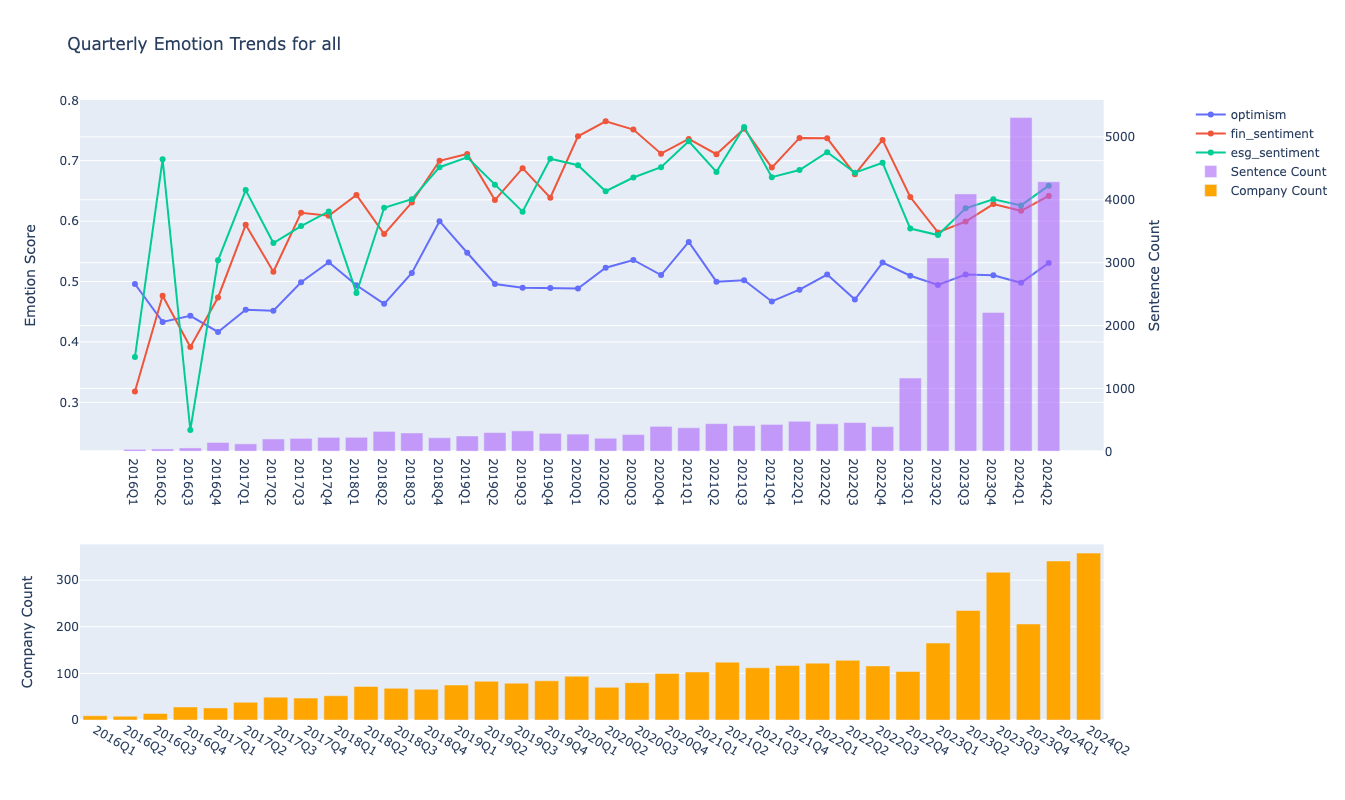

In [69]:
metrics = [
       'emotions.optimism',
       'analysis.fin_sentiment','analysis.esg_sentiment'	
       ]

plot_metric_and_sentence_trends(events_by_quarter, metrics, show_company_count=True)

The graph above illustrates the changes in AI mentions and the associated optimism, financial, and ESG sentiments over time. It shows a gradual increase in the number of AI mentions, rising from just 32 in 2016 to 393 by the fourth quarter of 2022. However, following the public release of ChatGPT and it's advanced models, mentions surged dramatically, tripling to 3076 in the first quarter of 2023. This trend continued into the first quarter of 2024, with AI mentions reaching 5307, approximately 14 times the amount recorded in the fourth quarter of 2022. This growth can be attributed not only to the increased frequency of AI mentions but also to a rise in the number of companies focusing on AI, as indicated by the second bar plot. Interestingly, despite the heightened focus on AI, the graph reveals a decline in optimism, as well as a decrease in financial and ESG sentiments, following the rapid increase in AI-related discussions.

In regards to the latter, we also plot the fear and confusion emotions around AI mentions where we observe an increase after the popularization of AI, which might be perhaps explained by the realizations of the issues and the challanges of wider AI adoption.

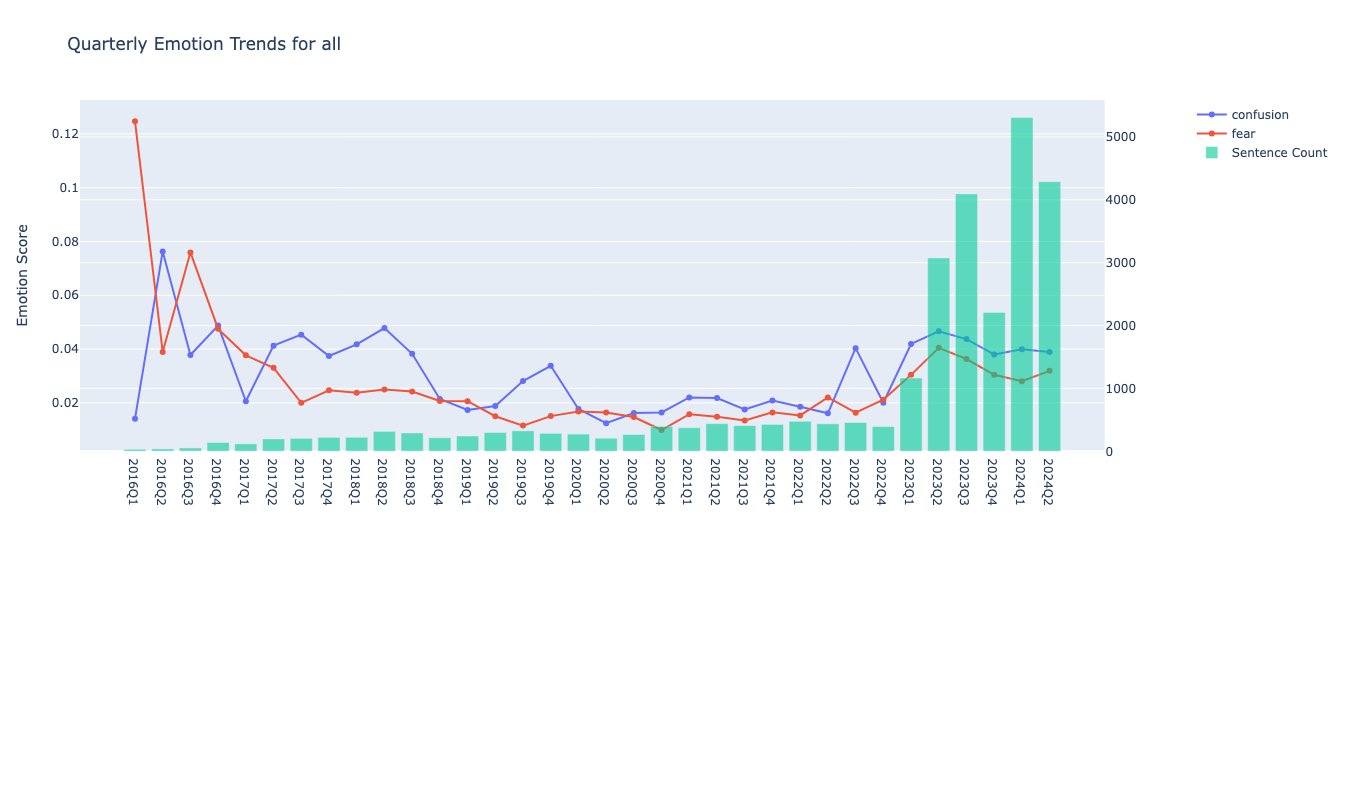

In [70]:
metrics = [
           'emotions.confusion', 'emotions.fear',
       ]

plot_metric_and_sentence_trends(events_by_quarter, metrics)

### Sectoral view of the analysis
Next we dive into the sectoral analysis of the similar trends for which we use our ***group_dataset*** function and group our events data with the sector and the quarter as shown below.

In [71]:
group_cols = ['TRBC Economic Sector Name', 'quarter']
events_by_sector = group_dataset(events_df, group_cols)
events_by_sector

,TRBC Economic Sector Name,quarter,analysis.fin_sentiment,analysis.esg_sentiment,emotions.admiration,...,emotions.pride,emotions.surprise,emotions.neutral,num_sentences,company_count
0,Basic Materials,2016Q1,-0.200000,NaN,0.004286,...,0.000000,0.000000,0.141429,7,1
1,Consumer Non-Cyclicals,2016Q1,-0.067000,-0.010000,0.002000,...,0.021000,0.000000,0.051000,10,2
2,Consumer Cyclicals,2016Q1,0.645000,0.000000,0.045000,...,0.210000,0.020000,0.145000,2,2
3,Technology,2016Q1,0.842308,0.755000,0.045385,...,0.073846,0.000000,0.223846,13,4
4,Consumer Non-Cyclicals,2016Q2,0.040000,NaN,0.000769,...,0.003077,0.003077,0.103077,13,3
...,...,...,...,...,...,...,...,...,...,...,...
270,Financials,2024Q2,0.494128,0.625614,0.022844,...,0.026239,0.003394,0.213303,113,25
271,Healthcare,2024Q2,0.654419,0.601892,0.049380,...,0.058217,0.001938,0.251473,131,28
272,Industrials,2024Q2,0.648856,0.611548,0.035425,...,0.047859,0.008974,0.217595,343,51
273,Technology,2024Q2,0.639883,0.660663,0.044959,...,0.074994,0.003873,0.263479,3167,140


First, let's plot the sectoral distributaion of the frequency of AI mentions in the transcripts alongside with the distribution of the specific emotion or sentiment.

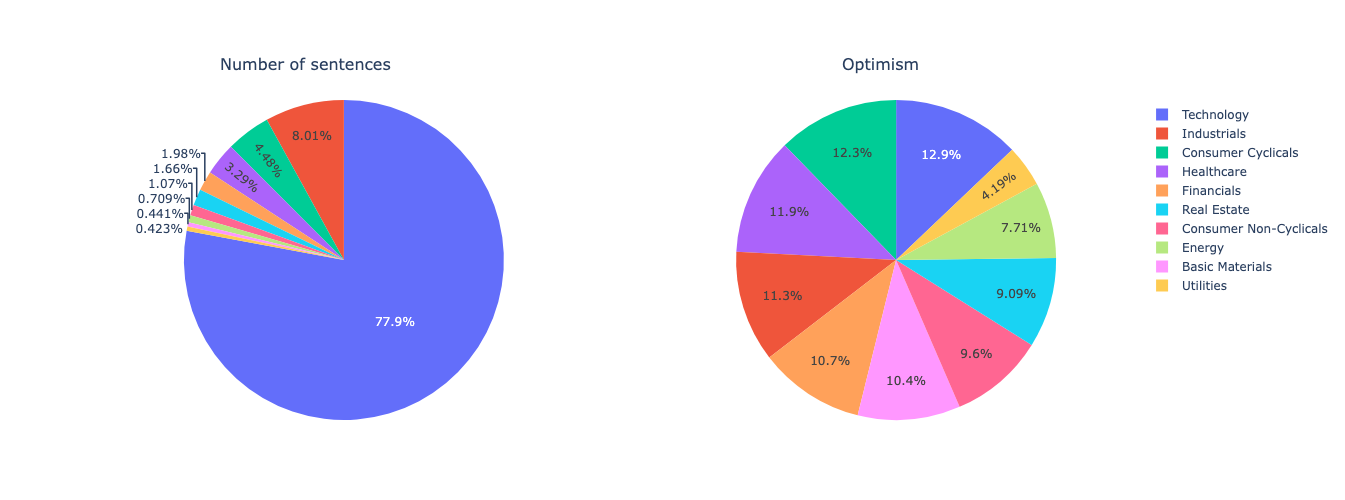

In [72]:
plot_sectoral_analysis(events_by_sector, 'emotions.optimism')

As expected, the technology sector is the primary driver of AI development and the most optimistic about it. Companies in consumer cyclical, healthcare, financials, and industrials are also highly optimistic, while the utilities and energy sectors are the least enthusiastic about AI. While you can experiment with various emotions and sentiments here, below we demonstarte an area plot to show how the emotions/sentiments across different sectors evolved over time.

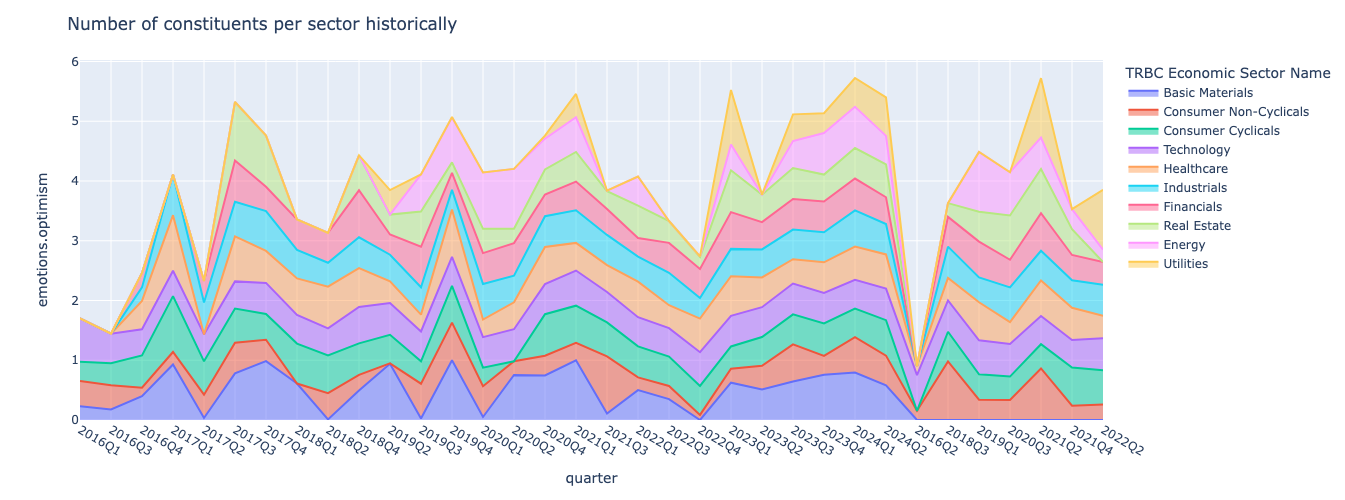

In [73]:
plot_sector_area_trend(events_by_sector, 'emotions.optimism')

Finally, we select a sector and show the number of sentences, companies and emotional shifts within the sector utilizing the ***plot_metric_and_sentence_trends*** function.

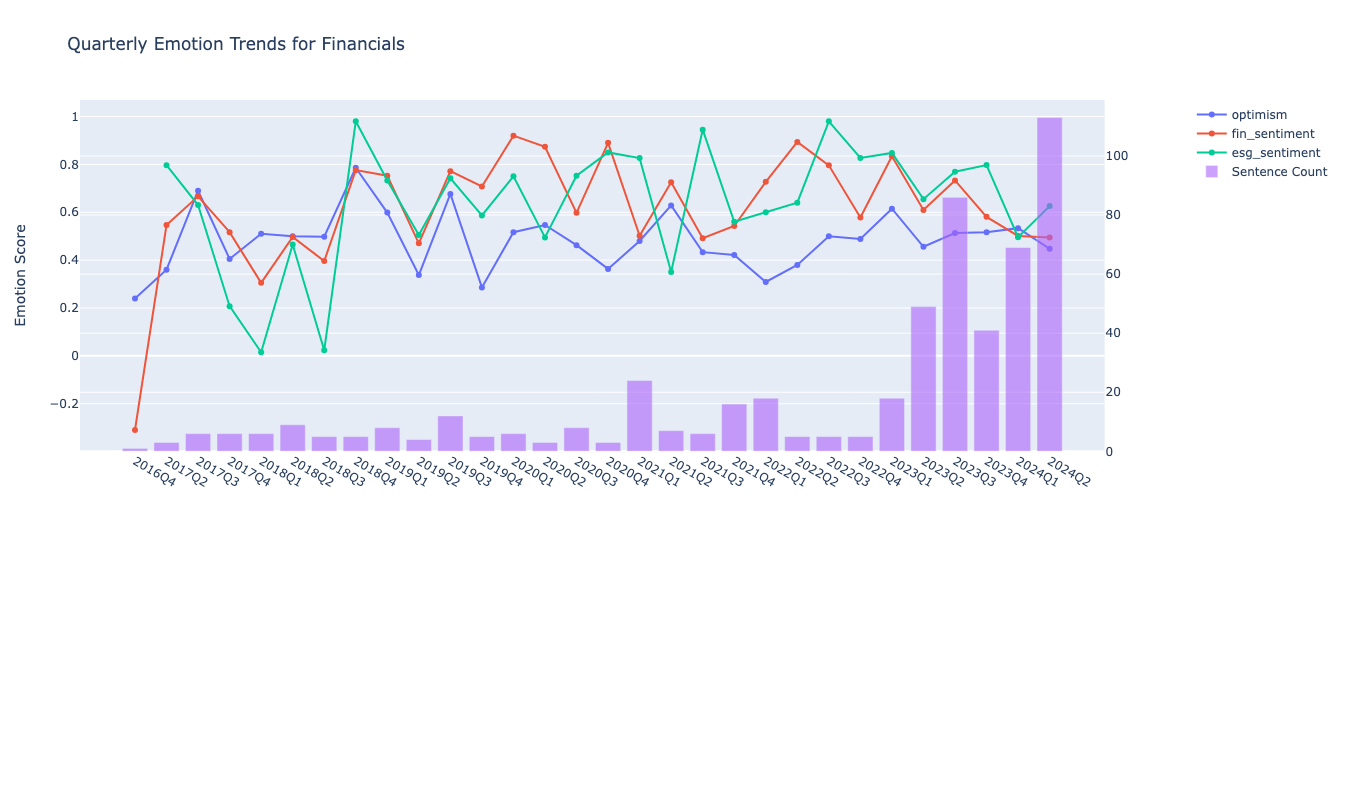

In [74]:
sector = 'Financials'
data  = events_by_sector[events_by_sector['TRBC Economic Sector Name'] == sector]
metrics = [
       'emotions.optimism',
       'analysis.fin_sentiment','analysis.esg_sentiment']

plot_metric_and_sentence_trends(data, metrics, name= sector)

### Company level view of the analysis
Here, we show also the company level view of the analysis, first by grouping events dataset by Instrument and the quarter.

In [75]:
group_cols = ['Instrument', 'quarter', 'start_date']
events_by_company = group_dataset(events_df, group_cols)
events_by_company

,Instrument,quarter,start_date,analysis.fin_sentiment,analysis.esg_sentiment,...,emotions.pride,emotions.surprise,emotions.neutral,num_sentences,company_count
0,MAT.OQ,2016Q1,2016-02-01,0.920000,NaN,...,0.410000,0.030000,0.090000,1,1
1,NVDA.OQ,2016Q1,2016-02-17,0.945000,NaN,...,0.150000,0.000000,0.495000,2,1
2,META.OQ,2016Q1,2016-01-27,0.764286,0.755000,...,0.081429,0.000000,0.262857,7,1
3,GOOG.OQ,2016Q1,2016-02-01,0.926667,NaN,...,0.030000,0.000000,0.006667,3,1
4,CCL.N,2016Q1,2016-03-30,0.370000,0.000000,...,0.010000,0.010000,0.200000,1,1
...,...,...,...,...,...,...,...,...,...,...,...
3691,MDB.OQ,2024Q2,2024-05-30,0.552500,0.731667,...,0.022222,0.000000,0.260833,37,1
3692,CERT.OQ,2024Q2,2024-05-07,0.943333,0.803333,...,0.000000,0.026667,0.243333,3,1
3693,MCO.N,2024Q2,2024-05-02,0.181667,0.480000,...,0.000000,0.006667,0.441667,6,1
3694,CDNS.OQ,2024Q2,2024-04-22,0.688413,0.559459,...,0.083651,0.000952,0.258095,63,1


First, let's look into the some of the emotions and sentiments for the top 10 companies by the number of AI mentions in the first quarter of 20224.

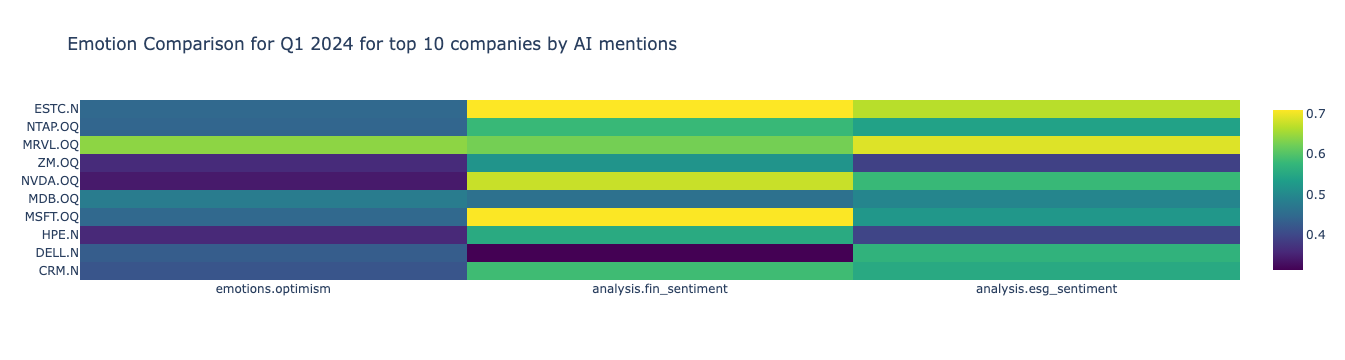

In [76]:
filtered_df = events_by_company[events_by_company['quarter'] == '2024Q1']
top_companies = filtered_df.nlargest(10, 'num_sentences').set_index('Instrument')
emotions = ['emotions.optimism','analysis.fin_sentiment','analysis.esg_sentiment']
heatmap_data = top_companies[emotions].reset_index()

fig = go.Figure(data=go.Heatmap(
    z=heatmap_data[emotions].values,
    x=emotions,
    y=heatmap_data['Instrument'],
    colorscale='Viridis')
    )

fig.update_layout(title='Emotion Comparison for Q1 2024 for top 10 companies by AI mentions')
fig.show()

According to the graph, Salesforce (CRM.N) has the most AI mentions during 2024Q1, however, it is not the most optimistic company around AI amongst the top 10. Below we demonstrate also how the nmber of mentions, emotions and sentiments changed over time for Salesforce. Please note, that the metrics can be updated if interested in the trends of the rest of the emotions, sentiments and the companies.

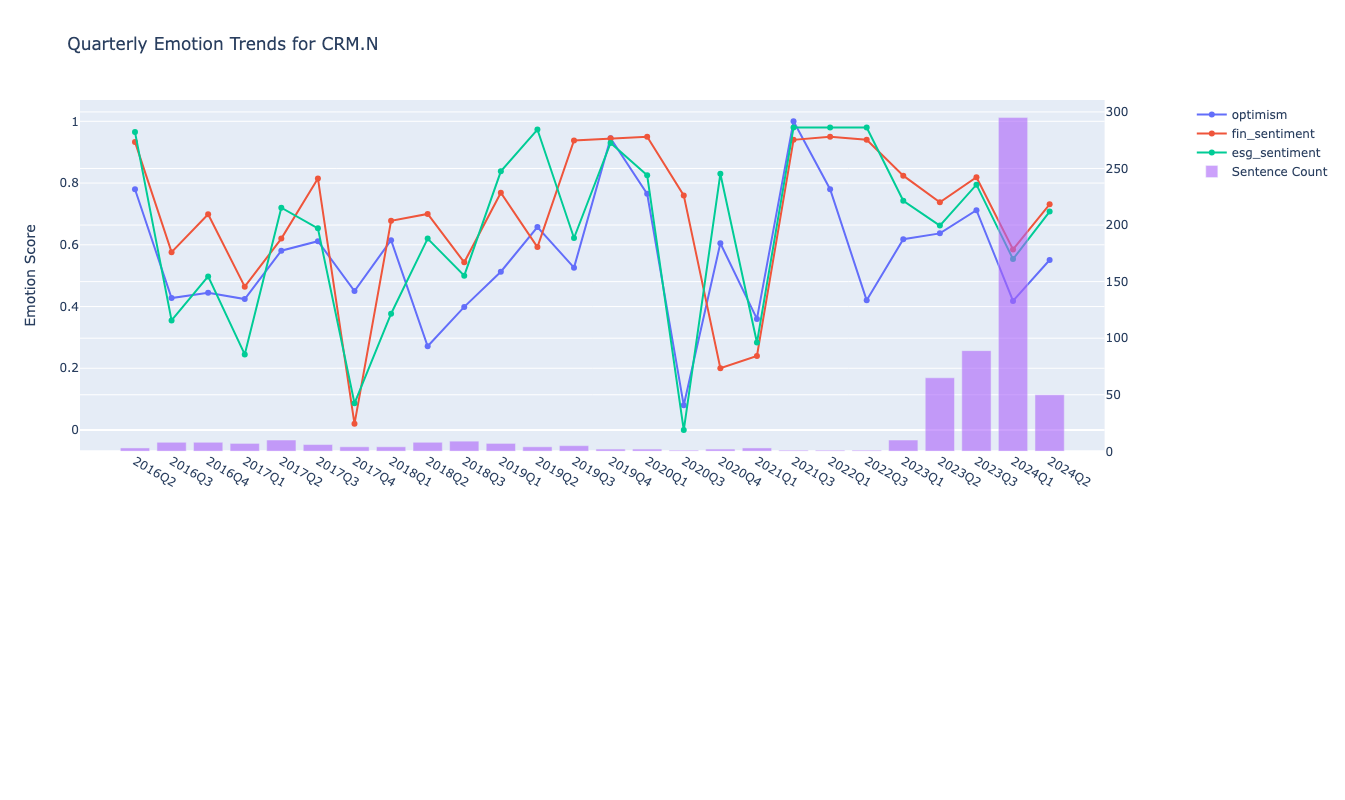

In [77]:
company = 'CRM.N'
data  = events_by_company[events_by_company['Instrument'] == company]
metrics = [       
    'emotions.optimism',
    'analysis.fin_sentiment','analysis.esg_sentiment'
    ]

plot_metric_and_sentence_trends(data, metrics, name = company)

## Section 3: Constructing Thematic Portfolios based on the AI mentions
In this section, we will construct portfolios and track their performance over the analysis period from the first quarter of 2016 to the second quarter of 2024. We employ two approaches for portfolio construction:

*   **Clustering Approach:** In this method, we divide our universe into two clusters based on the number of mentions, emotions, and sentiments.
*   **Quantile-Based Portfolios:** Here, we categorize companies into two quantiles based on a specific metric, which in our case is the number of sentences.

Refer to the relevant sub-section for detailed methodology.

### Getting the pricing data and calculating the returns
We use RD libraries for Python to get the historical close prices for our universe for the analysis period. To track the returns, we calculate the two-month returns of each stock in the portfolios following the event start date. The two-month window is chosen to account for the fact that companies may make announcements on different days throughout the quarter. This approach helps avoid including returns that occur after the subsequent earnings call event date.

Below we find the unique instruments from our event dataset and request close prices for January 2016 to July 2024.

In [78]:
rics  = events_by_company['Instrument'].drop_duplicates().to_list()
prices  = rd.get_history(rics, 'TRDPRC_1', start='2016-01-01', end='2024-07-30')

Next, we define the **calculate_period_returns** function which calculates the percentage returns for stocks over a specified period following an event date.

In [90]:
def calculate_period_returns(event_df: pd.DataFrame, prices_df: pd.DataFrame) -> pd.DataFrame:
    # define helper to calculate percentage change in series
    def calculate_pct_change(series):
        return (series.iloc[-1] - series.iloc[0]) / series.iloc[0] * 100

    returns = []
    end_dates = []
    for row in event_df.itertuples():
        # Define start and end dates for the period
        start = pd.to_datetime(row.start_date) + timedelta(days=1)
        end = start + relativedelta(months=2)
        ric = row.Instrument
        # Filter prices for the given period
        prices_ric = prices_df[ric][(prices_df[ric].index > start) & (prices_df[ric].index <= end)]
        # Calculate percentage change and store results
        returns.append(calculate_pct_change(prices_ric))
        end_dates.append(end)
    
    # Add returns and end dates to event_df
    event_df['returns'] = returns
    event_df['end_date'] = end_dates
    return event_df


events_by_company = calculate_period_returns(events_by_company, prices)
events_by_company

,Instrument,quarter,start_date,analysis.fin_sentiment,analysis.esg_sentiment,...,returns,end_date,cluster,quantile,weight
0,MAT.OQ,2016Q1,2016-02-01,0.920000,0.000000,...,7.871537,2016-04-02,0,1,0.062500
1,NVDA.OQ,2016Q1,2016-02-17,0.945000,0.000000,...,21.452037,2016-04-18,0,1,0.125000
2,META.OQ,2016Q1,2016-01-27,0.764286,0.755000,...,1.318956,2016-03-28,0,2,0.437500
3,GOOG.OQ,2016Q1,2016-02-01,0.926667,0.000000,...,3.158402,2016-04-02,0,2,0.187500
4,CCL.N,2016Q1,2016-03-30,0.370000,0.000000,...,-9.49763,2016-05-31,1,1,0.062500
...,...,...,...,...,...,...,...,...,...,...,...
3691,MDB.OQ,2024Q2,2024-05-30,0.552500,0.731667,...,4.57781,2024-07-31,0,2,0.009763
3692,CERT.OQ,2024Q2,2024-05-07,0.943333,0.803333,...,-16.178195,2024-07-08,0,1,0.000792
3693,MCO.N,2024Q2,2024-05-02,0.181667,0.480000,...,9.876193,2024-07-03,1,2,0.012048
3694,CDNS.OQ,2024Q2,2024-04-22,0.688413,0.559459,...,14.66902,2024-06-23,0,2,0.016623


### Portfolio Construction Approach 1: Clusttering our universe
At this step, we will cluster our universe into two groups using the KMeans algorithm, based on mentions, sentiments, and emotions as input features. The clustering is performed separately for each quarter to prevent look-ahead bias, ensuring that only data available up to that point in time is used for clustering.

The **cluster_companies** function below groups companies by quarter and then clusters them based on the provided features.

In [91]:
def cluster_companies(df:pd.DataFrame, features:list) ->tuple[pd.DataFrame, list]:
    def cluster_group(group):
        # Fill missing values (kmeans can't handle NaNs) and scale features
        for col in features:
            group[col] = group[col].fillna(0)
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(group[features])
        
        # Apply KMeans clustering
        kmeans = KMeans(n_clusters=2, random_state=42)
        group['cluster'] = kmeans.fit_predict(scaled_features)
        return group, kmeans.cluster_centers_

    clustered_df = pd.DataFrame()
    cluster_centers = []

    # Group by quarter and apply clustering
    for quarter, group in df.groupby('quarter'):
        clustered_group, centers = cluster_group(group)
        clustered_df = pd.concat([clustered_df, clustered_group])
        cluster_centers.append({quarter: centers})

    return clustered_df, cluster_centers


In [103]:
features = [
        'analysis.fin_sentiment', 'analysis.esg_sentiment','emotions.admiration', 
        'emotions.anger', 'emotions.annoyance', 'emotions.approval', 
        'emotions.confusion', 'emotions.disappointment', 'emotions.disapproval', 
        'emotions.fear', 'emotions.gratitude', 'emotions.optimism', 
        'emotions.pride', 'emotions.surprise', 'emotions.neutral', 
        'num_sentences'
]

events_by_company, cluster_means = cluster_companies(events_by_company, features)
events_by_company

,Instrument,quarter,start_date,analysis.fin_sentiment,analysis.esg_sentiment,...,returns,end_date,cluster,quantile,weight
0,MAT.OQ,2016Q1,2016-02-01,0.920000,0.000000,...,7.871537,2016-04-02,0,1,0.142857
1,NVDA.OQ,2016Q1,2016-02-17,0.945000,0.000000,...,21.452037,2016-04-18,0,1,0.285714
2,META.OQ,2016Q1,2016-01-27,0.764286,0.755000,...,1.318956,2016-03-28,0,2,0.280000
3,GOOG.OQ,2016Q1,2016-02-01,0.926667,0.000000,...,3.158402,2016-04-02,0,2,0.120000
4,CCL.N,2016Q1,2016-03-30,0.370000,0.000000,...,-9.49763,2016-05-31,1,1,0.142857
...,...,...,...,...,...,...,...,...,...,...,...
3691,MDB.OQ,2024Q2,2024-05-30,0.552500,0.731667,...,4.57781,2024-07-31,0,2,0.009448
3692,CERT.OQ,2024Q2,2024-05-07,0.943333,0.803333,...,-16.178195,2024-07-08,0,1,0.008065
3693,MCO.N,2024Q2,2024-05-02,0.181667,0.480000,...,9.876193,2024-07-03,1,2,0.001532
3694,CDNS.OQ,2024Q2,2024-04-22,0.688413,0.559459,...,14.66902,2024-06-23,0,2,0.016088


Below we plot the cluster centers for the last quarter of the analysis to identify the cluster patterns.

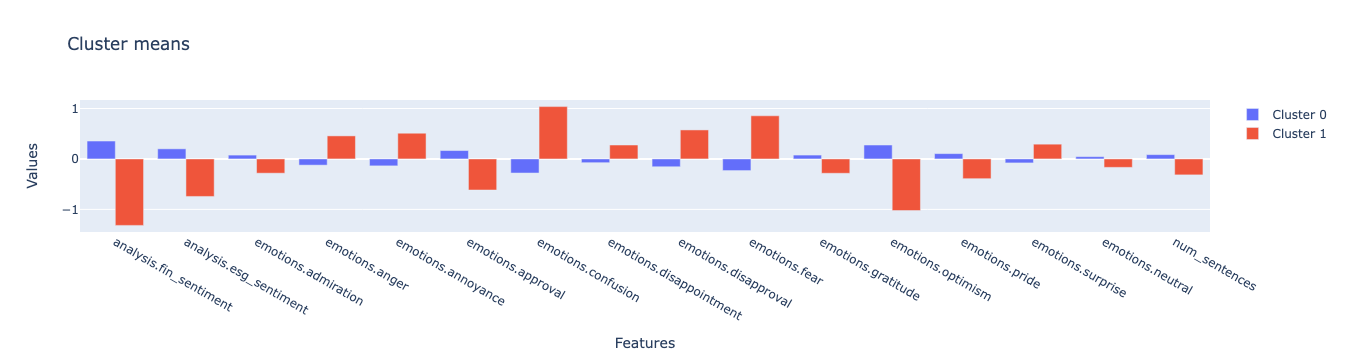

In [93]:
fig = go.Figure(data=[
    go.Bar(name='Cluster 0', x=features, y=list(cluster_means[-1].values())[0][0]),
    go.Bar(name='Cluster 1', x=features, y=list(cluster_means[-1].values())[0][1])
])

fig.update_layout(barmode='group', title='Cluster means',
                  xaxis_title='Features', yaxis_title='Values')

fig.show()

As shown in the plot above, Cluster 0 has higher means for positive sentiments, emotions, and the number of mentions, while showing lower means for negative emotions. Therefore, we will define Cluster 0 as the "higher mean" cluster and Cluster 1 as the "lower mean" cluster for the subsequent portfolio analysis.

### Portfolio Construction Approach 2: Assigning quantiles to the Universe
In this step, we will devide our quarterly universe into 2 quantiles based on a metric, e.g the number of sentences.

Below, we first define our metric and use ***compute_quantiles_per_quarter*** function which categorizes data into quantiles for each quarter based on a specified metric column. 

In [94]:
metric = 'num_sentences'

In [95]:
def compute_quantiles_per_quarter(df: pd.DataFrame, sentiment_column: str) -> pd.DataFrame:
    def preprocess_sentiment(x):
        # Add a small random noise to avoid ties in quantile calculation
        noise = np.random.normal(0, 1e-9, len(x))
        return x + noise
    
    def calculate_quartiles(x):
        try:
            x = preprocess_sentiment(x)
            # Compute quartiles
            return pd.qcut(x, 2, labels=False) + 1
        except ValueError:
            # Handle cases with insufficient data
            return pd.Series(np.nan, index=x.index)
    
    # Apply quantile calculation within each quarter
    df['quantile'] = df.groupby('quarter')[sentiment_column].transform(calculate_quartiles)
    
    return df

events_by_company = compute_quantiles_per_quarter(events_by_company, metric)
events_by_company

,Instrument,quarter,start_date,analysis.fin_sentiment,analysis.esg_sentiment,...,returns,end_date,cluster,quantile,weight
0,MAT.OQ,2016Q1,2016-02-01,0.920000,0.000000,...,7.871537,2016-04-02,0,1,0.062500
1,NVDA.OQ,2016Q1,2016-02-17,0.945000,0.000000,...,21.452037,2016-04-18,0,1,0.125000
2,META.OQ,2016Q1,2016-01-27,0.764286,0.755000,...,1.318956,2016-03-28,0,2,0.437500
3,GOOG.OQ,2016Q1,2016-02-01,0.926667,0.000000,...,3.158402,2016-04-02,0,2,0.187500
4,CCL.N,2016Q1,2016-03-30,0.370000,0.000000,...,-9.49763,2016-05-31,1,1,0.062500
...,...,...,...,...,...,...,...,...,...,...,...
3691,MDB.OQ,2024Q2,2024-05-30,0.552500,0.731667,...,4.57781,2024-07-31,0,2,0.009763
3692,CERT.OQ,2024Q2,2024-05-07,0.943333,0.803333,...,-16.178195,2024-07-08,0,1,0.000792
3693,MCO.N,2024Q2,2024-05-02,0.181667,0.480000,...,9.876193,2024-07-03,1,2,0.012048
3694,CDNS.OQ,2024Q2,2024-04-22,0.688413,0.559459,...,14.66902,2024-06-23,0,2,0.016623


### Calculating and visualizing the portfolio returns

As already mentioned, we employ two approaches for portfolio construction: one based on quantiles and the other based on clusters. For each approach, we create both equal-weighted and weighted portfolios based on the provided metric. 

The function below calculates and adds weights for each universe per quarter. Note that it requires the event DataFrame, the metric, and the portfolio type as inputs, with the portfolio type being crucial for correct grouping to calculate the weights.

In [96]:
def calculate_weights(df: pd.DataFrame, metric:str = 'num_sentences', portf_type:str = 'quantile')-> pd.DataFrame:
    # Normalize sentiment values if there are any negative values
    if (df[metric] < 0).any():
        scaler = MinMaxScaler()
        df['normalized_sentiment'] = scaler.fit_transform(np.array(df[metric]).reshape(-1, 1))
        metric = 'normalized_sentiment'
    
    # Calculate total sentiment value for each (quarter, cluster) combination
    total_cluster_value = df.groupby(['quarter', portf_type])[metric].transform('sum')
    
    # Compute weights as the ratio of individual sentiment to total cluster sentiment
    df['weight'] = df[metric] / total_cluster_value
    return df

Now, that we have all the necessary components for constructing, rebalancing, and calculating the returns of our portfolios, we define the ***rebalance_portfolio_and_calculate_returns*** function. As the name suggests, this function constructs, rebalances, and calculates portfolios based on the specified portfolio types. It returns detailed portfolio rebalancing results, including information on portfolio assets and returns for each quarter, as well as summary results with only the total number of assets and aggregated returns for each quarter.

In [97]:
def rebalance_portfolio_and_calculate_returns(df: pd.DataFrame, portf_type:str = 'quantile')-> tuple[dict, dict]:
    # Drop rows with missing values in the specified columns
    df = df.dropna(subset=portf_type).dropna(subset='returns')
    
    # Initialize dictionaries for detailed and summary portfolio data
    portf_detailed = {}
    portf_summary = {}
    # Map portfolio types to descriptive names
    portf_name_dict ={'quantile': {1:'lowest quantile', 2:'highest quantile'},
                     'cluster': {0: 'higher mean', 1: 'lower mean'}}
    
    # Process each unique portfolio type
    for portf_name in sorted(df[portf_type].unique()):
        portf_data= df[df[portf_type] == portf_name]
        port_name_key = portf_name_dict[portf_type][portf_name]
        portf_detailed[port_name_key] = []
        portf_summary[port_name_key] = []
        portf_summary['weighted'] = []

        # Process each unique quarter
        for quarter in portf_data['quarter'].astype(str).unique():
            quarter_data = portf_data[portf_data['quarter'] == quarter]
            assets = quarter_data['Instrument'].tolist()
            returns = quarter_data['returns'].tolist()

            # Calculate weighted average returns if portfolio type is 'quantile' and add to the summary dict. Cluster based approach is equal-weighted only
            # if portf_type == 'quantile':
            weights = quarter_data['weight'].tolist()
            weighted_avg_returns = np.dot(returns, weights)
            portf_summary['weighted'].append({
                quarter: {
                    'return': weighted_avg_returns,
                    'n_assets': len(df[df['quarter'] == quarter]['Instrument'].unique())
                }
            })

            # Calculate average returns
            avg_return = np.mean(returns)

            # Store detailed and summary metrics
            portf_detailed[port_name_key].append({
                quarter: {
                    'assets': assets,
                    'returns': returns,
                    'avg_return': avg_return
                }
            })
            portf_summary[port_name_key].append({
                quarter: {
                    'return': avg_return,
                    'n_assets': len(assets)
                }
            })
    return portf_detailed, portf_summary



So, let's now add the weights to our dataset and run the rebalance_portfolio_and_calculate_returns function below for cluster based approach.

In [98]:
portf_type = 'cluster'
events_by_company = calculate_weights(events_by_company, metric, portf_type)
portfolio_detailed_view, portfolio_summary_view = rebalance_portfolio_and_calculate_returns(events_by_company, portf_type)
print('portfolio_names:', list(portfolio_summary_view.keys()))
portfolio_summary_view

portfolio_names: ['higher mean', 'weighted', 'lower mean']


{'higher mean': [{'2016Q1': {'return': 7.816555773905836, 'n_assets': 6}},
  {'2016Q2': {'return': 5.957700314568425, 'n_assets': 1}},
  {'2016Q3': {'return': 0.3250325999746272, 'n_assets': 10}},
  {'2016Q4': {'return': 4.530157076428586, 'n_assets': 27}},
  {'2017Q1': {'return': 0.664402158585572, 'n_assets': 25}},
  {'2017Q2': {'return': 1.4567868466435603, 'n_assets': 8}},
  {'2017Q3': {'return': 5.329293686009922, 'n_assets': 39}},
  {'2017Q4': {'return': 3.058630150894592, 'n_assets': 26}},
  {'2018Q1': {'return': -0.6940007730958399, 'n_assets': 49}},
  {'2018Q2': {'return': 3.5879140665843767, 'n_assets': 53}},
  {'2018Q3': {'return': -5.1956197820998415, 'n_assets': 29}},
  {'2018Q4': {'return': -2.996744060385849, 'n_assets': 4}},
  {'2019Q1': {'return': 6.7169795675636585, 'n_assets': 73}},
  {'2019Q2': {'return': 2.8162164406809342, 'n_assets': 35}},
  {'2019Q3': {'return': -1.2243359064464499, 'n_assets': 75}},
  {'2019Q4': {'return': 7.42952935682318, 'n_assets': 45}},
  

The dictionary above contains information about the returns and number of assets per quarter for each portfolio. Below, we define ***summarize_results_by*** function, which transforms the portfolio_summary_view dictionary into a dataframe for subsequent visualisation of the results.

In [99]:
def summarize_results_by(portfolio_summary:dict, port_name:str, by:str) -> pd.DataFrame:
    df = pd.DataFrame()
    # Iterate through each key in the portfolio summary
    for key in portfolio_summary.keys():
        key_df = pd.DataFrame(portfolio_summary[key])
        
        # Extract diagonal values and the relevant data
        diagonal_values = np.diag(key_df)
        data = [ret[by] for ret in diagonal_values]
        
        # Create a new DataFrame with extracted data
        new_df = pd.DataFrame([data], columns=key_df.columns)
        new_df[port_name] = key
        
        # Concatenate new data to the main DataFrame
        df = pd.concat([df, new_df])
    
    # Set the specified portfolio name as the index
    df = df.set_index(port_name)
    
    return df

Further, we run this function for the number of assets and returns (with cumulative sums applied to returns) to have the respective dataframes

In [100]:
assets = summarize_results_by(portfolio_summary_view, portf_type, 'n_assets').T
rets =  summarize_results_by(portfolio_summary_view, portf_type, 'return').T.cumsum()
rets

cluster,higher mean,weighted,lower mean
2016Q1,7.816556,8.010933,2.968702
2016Q2,13.774256,18.647302,8.237119
2016Q3,14.099289,16.295423,6.863850
2016Q4,18.629446,23.759538,14.327965
2017Q1,19.293848,22.998760,13.567188
...,...,...,...
2023Q2,51.485046,59.865518,26.475360
2023Q3,46.018908,56.705432,20.918625
2023Q4,61.014972,70.387769,35.572904
2024Q1,62.579201,70.912383,37.569839


Finally, we show the cumulative returns along with the number of assets per portfolio over the analysis period.

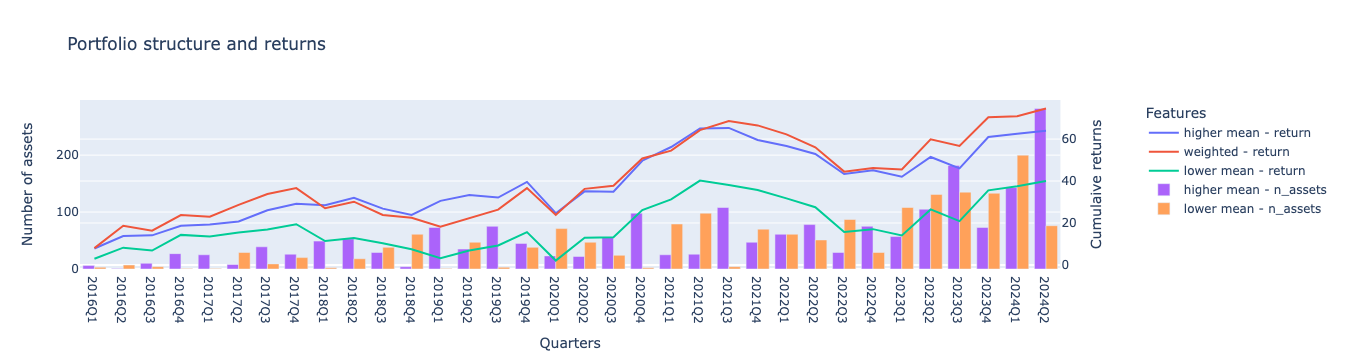

In [101]:
def visulize_results(rets_df:pd.DataFrame, assets_df:pd.DataFrame):
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    for col in rets_df.columns:
        fig.add_trace(
            go.Scatter(x=rets_df.index, y=rets_df[col].dropna(), mode='lines', name=f"{col} - return"),
            secondary_y=True,
        )

    for col in assets_df.columns.drop('weighted'):
        fig.add_trace(
            go.Bar(x=assets_df.index, y=assets_df[col], name=f"{col} - n_assets"),
            secondary_y=False,
        )

    fig.update_layout(
        title_text="Portfolio structure and returns",
        xaxis_title="Quarters",
        yaxis_title="Number of assets",
        legend_title="Features"
    )

    fig.update_yaxes(title_text="Number of assets", secondary_y=False)
    fig.update_yaxes(title_text="Cumulaive returns", secondary_y=True)

    fig.show()
visulize_results(rets, assets)

The graph above illustrates the number of assets and returns for each portfolio. The highest cumulative returns are observed in the weighted portfolio, followed by the higher mean portfolio. The lower mean portfolio, which includes companies with lower positive and higher negative emotions, has the lowest returns. Regarding asset allocation, the number of assets in each cluster varies significantly from quarter to quarter. 

Below, we will examine the results for quantile-based portfolios.

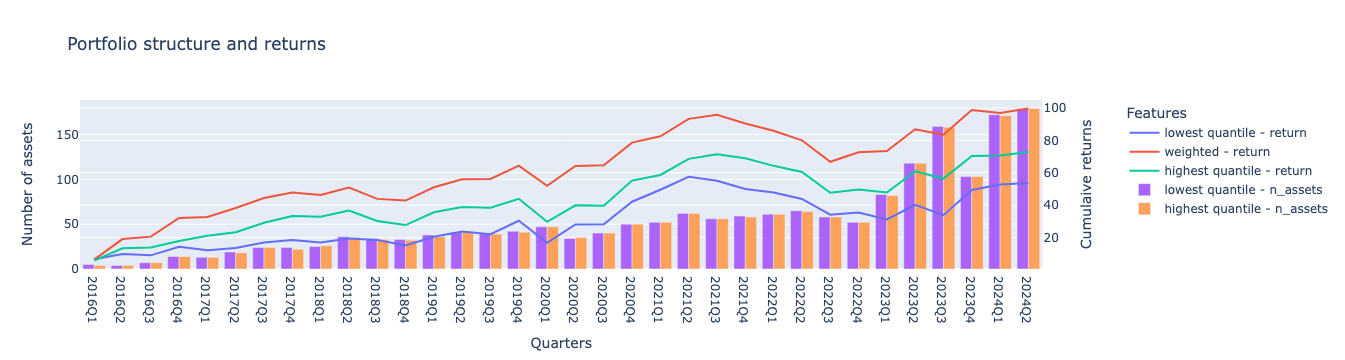

In [102]:
portf_type = 'quantile'
events_by_company = calculate_weights(events_by_company, metric, portf_type)
portfolio_detailed_view, portfolio_summary_view = rebalance_portfolio_and_calculate_returns(events_by_company, portf_type)
assets = summarize_results_by(portfolio_summary_view, portf_type, 'n_assets').T
rets =  summarize_results_by(portfolio_summary_view, portf_type, 'return').T.cumsum()
visulize_results(rets, assets)

The cumulative portfolio returns generally align with the clustering-based approach, with the weighted portfolio having the largest return. The gap between the weighted portfolio and the highest quantiles is significant. Additionally, both the weighted and highest return portfolios outperform the cluster-based weighted and higher mean results. In terms of the number of assets, as expected, the highest and lowest quantile portfolios have an almost equal distribution.

## Final remarks

The article demonstrated how  LSEG MarketPsych Transcripts Analytics (MTA) API can be used to ingest sentences with AI mentions from corporate transcripts and perform exploratory and portfolio construction analysis. The main goal was to examine a. how the frequency and sentiment of AI mentions in earnings calls have evolved over time and per sector and b. to assess whether these patterns can be leveraged to build effective thematic portfolios.

The methodologies and examples presented are primarily intended for educational and exploratory purposes. Although we observed positive results for the constructed thematic portfolios—where portfolios comprised of companies with frequent AI mentions and overall positive sentiments outperformed those with lower rankings—these findings should be considered preliminary insights. They serve as a foundation for further investigation rather than conclusive evidence. Users are encouraged to experiment with different data universes, search terms, and portfolio construction strategies.